In [1]:
import pandas as pd

In [71]:
df = pd.read_csv("data.csv")

In [72]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,17089,2012-12-19,4,1,12,19,0,3,1,1,0.38,0.3939,0.50,0.3881,7,329,336
10882,17090,2012-12-19,4,1,12,20,0,3,1,1,0.36,0.3485,0.57,0.2239,10,231,241
10883,17091,2012-12-19,4,1,12,21,0,3,1,1,0.34,0.3182,0.61,0.2239,4,164,168
10884,17092,2012-12-19,4,1,12,22,0,3,1,1,0.34,0.3485,0.61,0.0896,12,117,129


In [73]:
df = df.drop(columns=["instant", "dteday", "casual", "registered"])

In [74]:
len(df.columns)

13

In [114]:
train = df.sample(frac=0.8,random_state=200)
val = train.sample(frac=0.2, random_state=200)
train = train.drop(val.index)

test = df.drop(train.index)

In [115]:
import torch
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [116]:
c = Counter(df["cnt"])

<BarContainer object of 822 artists>

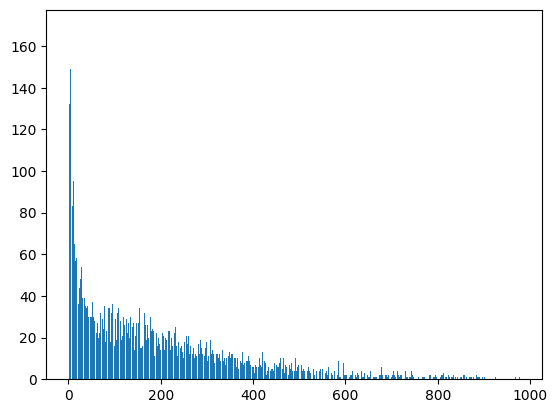

In [117]:
plt.bar(c.keys(), c.values())

# Data loading

In [118]:
train_labels = torch.tensor(train.values[:, -1].astype(np.int64))
train_data = train.values[:,:-1].astype(np.float32)

train_dataset = data.TensorDataset(torch.from_numpy(train_data), train_labels)

val_labels = torch.tensor(val.values[:, -1].astype(np.int64))
val_data = val.values[:,:-1].astype(np.float32)

val_dataset = data.TensorDataset(torch.from_numpy(val_data), val_labels)

test_labels = torch.tensor(test.values[:, -1].astype(np.int64))
test_data = test.values[:,:-1].astype(np.float32)

test_dataset = data.TensorDataset(torch.from_numpy(test_data), test_labels)

In [119]:
BATCH_SIZE = 256
train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [120]:
class BikePredictor(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 512)
        self.act_fn = nn.LeakyReLU()
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = nn.Dropout(p=0.25)(x)
        x = self.linear2(x)
        x = self.act_fn(x)
        x = nn.Dropout(p=0.25)(x)
        x = self.linear3(x)
        return x

In [121]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

cuda


In [122]:
model = BikePredictor(12, 1)
model.to(device)

BikePredictor(
  (linear1): Linear(in_features=12, out_features=512, bias=True)
  (act_fn): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)

In [123]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, y_pred, y_true):
        log_pred = torch.log(torch.clamp(y_pred, min=0) + 1)
        log_true = torch.log(y_true + 1)
        loss = torch.sqrt(torch.mean((log_pred - log_true) ** 2))
        return loss

loss_module = RMSLELoss()

# Training

In [124]:
EPOCHS = 100
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    for data_inputs, data_labels in train_data_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

        prediction = model(data_inputs)
        prediction = prediction.squeeze(dim=1)

        loss = loss_module(prediction, data_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()


    avg_train_loss = total_train_loss / len(train_data_loader)


    model.eval()
    with torch.no_grad():
        for data_inputs, data_labels in val_data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            prediction = model(data_inputs)
            prediction = prediction.squeeze(dim=1)

            loss = loss_module(prediction, data_labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_data_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}| Train Loss = {avg_train_loss:.4f}| Val Loss = {avg_val_loss:.4f}")

Epoch 1| Train Loss = 1.3558| Val Loss = 1.0580
Epoch 2| Train Loss = 1.0315| Val Loss = 0.9337
Epoch 3| Train Loss = 0.8917| Val Loss = 0.8013
Epoch 4| Train Loss = 0.7814| Val Loss = 0.7300
Epoch 5| Train Loss = 0.7166| Val Loss = 0.6992
Epoch 6| Train Loss = 0.6857| Val Loss = 0.6918
Epoch 7| Train Loss = 0.6709| Val Loss = 0.6442
Epoch 8| Train Loss = 0.6213| Val Loss = 0.6369
Epoch 9| Train Loss = 0.6071| Val Loss = 0.6302
Epoch 10| Train Loss = 0.6007| Val Loss = 0.5801
Epoch 11| Train Loss = 0.5854| Val Loss = 0.5874
Epoch 12| Train Loss = 0.5729| Val Loss = 0.5848
Epoch 13| Train Loss = 0.5668| Val Loss = 0.5806
Epoch 14| Train Loss = 0.5617| Val Loss = 0.5653
Epoch 15| Train Loss = 0.5511| Val Loss = 0.5780
Epoch 16| Train Loss = 0.5401| Val Loss = 0.5437
Epoch 17| Train Loss = 0.5355| Val Loss = 0.5425
Epoch 18| Train Loss = 0.5389| Val Loss = 0.5422
Epoch 19| Train Loss = 0.5385| Val Loss = 0.5462
Epoch 20| Train Loss = 0.5347| Val Loss = 0.5324
Epoch 21| Train Loss = 0.5214

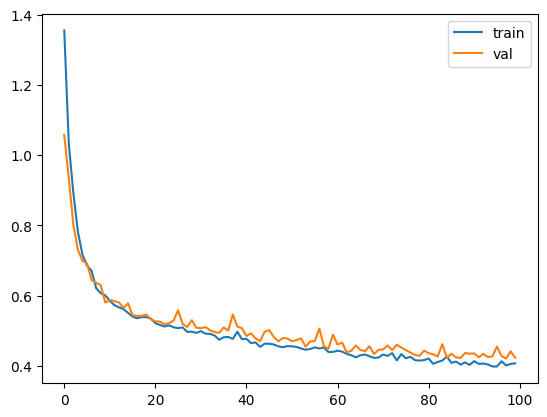

In [125]:
plt.plot(np.arange(EPOCHS), train_losses)
plt.plot(np.arange(EPOCHS), val_losses)
plt.legend(["train", "val"])

# Final evaluation

In [129]:
test_loss = 0
with torch.no_grad():
    for data_inputs, data_labels in test_data_loader:

        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        prediction = model(data_inputs)
        prediction = prediction.squeeze(dim=1)

        test_loss += loss_module(prediction, data_labels).item()

test_avg_loss = test_loss / len(test_data_loader)

print(f"Test loss: {test_avg_loss:.4f}")



Test loss: 0.3982


# Saving the model

In [133]:
state_dict = model.state_dict()
torch.save(state_dict, "bikes_good.tar")